<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/intro/jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# JAX <a class="anchor" id="jax"></a>

[JAX](https://github.com/google/jax) is a  version of Numpy that runs fast on CPU, GPU and TPU.
In addition to having a fast backend, JAX supports
several useful python-level program transformations:

* [vmap](#vmap), vectorized map operator for automatic vectorization or batching.
* [autograd](#AD), for automatic differentiation.
* [jit](#jit), just in time compiler for speeding up your code (even on a CPU!).

We illustrate these below.

More details can be found at the 
* [official JAX quickstart page](https://github.com/google/jax#quickstart-colab-in-the-cloud).
* [official JAX quickstart colab](https://colab.research.google.com/github/google/jax/blob/master/docs/notebooks/quickstart.ipynb#scrollTo=SY8mDvEvCGqk)

* ["You don't know jax"](https://colinraffel.com/blog/you-don-t-know-jax.html), blog post by Colin Raffel


Other relevant PyProbML notebooks:
* [Autodiff in JAX](https://github.com/probml/pyprobml/blob/master/notebooks/opt/opt.ipynb#AD-jax) 
* [SGD using JAX](https://github.com/probml/pyprobml/blob/master/notebooks/opt/opt.ipynb#SGD-jax)
* [Linear algebra](https://github.com/probml/pyprobml/blob/master/notebooks/linalg/linalg.ipynb)

Various libraries build on top of JAX, including the following:
* [FLAX](https://github.com/google/flax), DL library for JAX from Google, similar to PyTorch. Implements Module abstraction and has other goodies.
* [Haiku](https://github.com/deepmind/dm-haiku), DL library for JAX from Deepmind. Implements Module abstraction.
* [Stax](https://github.com/google/jax/blob/master/jax/experimental/stax.py),a minimal functional DL library that "ships with" JAX.
* [Trax](https://github.com/tensorflow/tensor2tensor/tree/master/tensor2tensor/trax), similar to the above, but more complex.
* [Optim](https://github.com/google/jax/blob/master/jax/experimental/optimizers.py), a small library of fast first-order optimization methods available
* [NumPyro](https://github.com/pyro-ppl/numpyro), a JAX backend for [Pyro](https://github.com/pyro-ppl/pyro) probabilistic modeling framework.




**Make sure you select 'GPU' from the 'Runtime' tab at the top of this page.**


In [1]:
# Standard Python libraries
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import time
import numpy as np
np.set_printoptions(precision=3)
import glob
import matplotlib.pyplot as plt
import PIL
import imageio

from IPython import display
%matplotlib inline

import sklearn

import seaborn as sns;
sns.set(style="ticks", color_codes=True)

import pandas as pd
pd.set_option('precision', 2) # 2 decimal places
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 100) # wide windows


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


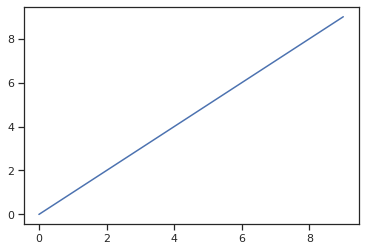

In [2]:
# Check we can plot stuff in the colab
plt.figure()
plt.plot(range(10))

In [0]:

# JAX is built in to Colab
# Install 
#!pip install --upgrade -q https://storage.googleapis.com/jax-releases/cuda$(echo $CUDA_VERSION | sed -e 's/\.//' -e 's/\..*//')/jaxlib-$(pip search jaxlib | grep -oP '[0-9\.]+' | head -n 1)-cp36-none-linux_x86_64.whl
#!pip install --upgrade -q jax



In [5]:

# Load JAX
import jax
import jax.numpy as np
import numpy as onp # original numpy
from jax import grad, hessian, jit, vmap
print("jax version {}".format(jax.__version__))
from jax.lib import xla_bridge
print("jax backend {}".format(xla_bridge.get_backend().platform))



jax version 0.1.67
jax backend gpu


In [4]:
# Check it works
from jax import random
key = random.PRNGKey(0)
x = random.normal(key, (5,5))
print(x)

[[ 2.516 -1.395 -0.863  0.641 -0.378]
 [-0.604  1.907 -0.179 -0.758 -0.516]
 [ 1.267 -0.123 -1.266 -0.173  1.066]
 [ 1.581 -2.028 -0.132 -0.145  0.215]
 [-0.695 -0.931 -0.898 -0.253 -0.349]]


### Vmap <a class="anchor" id="vmap"></a>


To illustrate vmap, consider a logistic regression model.

In [0]:
def sigmoid(x): return 0.5 * (np.tanh(x / 2.) + 1)

def predict_single(w, x):
    return sigmoid(np.dot(w, x)) # <(D) , (D)> = (1) # inner product
  
def predict_batch(w, X):
    return sigmoid(np.dot(X, w)) # (N,D) * (D,1) = (N,1) # matrix-vector multiply


D = 2
N = 3
onp.random.seed(42)
w = onp.random.randn(D)
X = onp.random.randn(N, D)
y = onp.random.randint(0, 2, N)

# We can apply predict_batch to a matrix of data, but we cannot apply predict_single in this way
# because the order of the arguments to np.dot is incorrect.

p1 = predict_batch(w, X)
try:
    p2 = predict_single(w, X)
except:
    print('cannot apply to batch')

cannot apply to batch


To avoid having to think about batch shape, it is often easier to write a function that works on single
input vectors. We can then apply this in a loop.

In [0]:
p3 = [predict_single(w, x) for x in X]
assert np.allclose(p1, p3)

Unfortunately, mapping down a list is slow.
Fortunately, JAX provides `vmap`, which has the same effect, but can be parallelized.

We first apply the `predict_single` function to its first arugment, w, to get a function that only
depends on x. We then vectorize this, and map the resulting modified function along rows (dimension 0)
of the data matrix.

In [0]:
from functools import partial

predict_single_w = partial(predict_single, w)
predict_batch_w = vmap(predict_single_w)
p4 = predict_batch_w(X)
p5 = vmap(predict_single, in_axes=(None, 0))(w, X)

assert np.allclose(p1, p4)
assert np.allclose(p1, p5)


### Autograd <a class="anchor" id="AD"></a>

In this section, we illustrate automatic differentiation by using it to compute the gradient of the negative log likelihood of a logistic regression model for each example.

In [0]:
def predict(weights, inputs):
    return sigmoid(np.dot(inputs, weights))

def loss(weights, inputs, targets):
    preds = predict(weights, inputs)
    logprobs = np.log(preds) * targets + np.log(1 - preds) * (1 - targets)
    return -np.sum(logprobs)

def loss2(params, data):
    return loss(params, data[0], data[1])

print(loss(w, X, y))
assert np.isclose(loss(w, X, y), loss2(w, (X,y)))

# Gradient function
grad_fun = grad(loss)

# Gradient of each example in the batch
grads = vmap(partial(grad_fun, w))(X,y)
print(grads)
assert grads.shape == (N,D)

grads2 = vmap(grad_fun, in_axes=(None, 0, 0))(w, X, y) 
assert np.allclose(grads, grads2)

grads3 = vmap(grad(loss2), in_axes=(None, 0))(w, (X, y)) 
assert np.allclose(grads, grads3)

# Gradient for entire batch
grad_sum = np.sum(grads, axis=0)
assert grad_sum.shape == (D,)

1.7016186
[[-0.306 -0.719]
 [-0.112 -0.112]
 [-0.532 -0.258]]


In [0]:
# We can We can also compute Hessians, as we illustrate below.
from jax import hessian

H0 = hessian(loss)(w, X[0,:], y[0])
print(H0)

hessian_fun = hessian(loss)
H = vmap(hessian_fun, in_axes=(None, 0, 0))(w, X, y) 
print(H.shape)



[[0.105 0.246]
 [0.246 0.578]]
(3, 2, 2)



### JIT (just in time compilation) <a class="anchor" id="JIT"></a>

In this section, we illustrate how to use the Jax JIT compiler to make code go faster (even on a CPU). However, it does not work on arbitrary Python code, as we explain below.




In [0]:
grad_fun_jit = jit(grad_fun) # speedup gradient function
grads_jit = vmap(partial(grad_fun_jit, w))(X,y)
assert np.allclose(grads, grads_jit)


In [0]:
# We can apply JIT to non ML applications as well.

def slow_f(x):
  # Element-wise ops see a large benefit from fusion
  return x * x + x * 2.0

x = np.ones((5000, 5000))
fast_f = jit(slow_f)
%timeit -n10 -r3 fast_f(x)  
%timeit -n10 -r3 slow_f(x)  

The slowest run took 4.41 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 3: 4.64 ms per loop
10 loops, best of 3: 12.5 ms per loop


We can also add the `%jit` decorator in front of a function.

Note that JIT compilation requires that the control flow through the function  can be determined by the shape (but not concrete value) of its inputs. The function below violates this, since when x<3, it takes one branch, whereas when x>= 3, it takes the other.

In [0]:
@jit
def f(x):
  if x < 3:
    return 3. * x ** 2
  else:
    return -4 * x

# This will fail!
try:
  print(f(2))
except Exception as e:
  print("ERROR:", e)
  


ERROR: Abstract value passed to `bool`, which requires a concrete value. The function to be transformed can't be traced at the required level of abstraction. If using `jit`, try using `static_argnums` or applying `jit` to smaller subfunctions instead.


We can fix this by telling JAX to trace the control flow through the function using concrete values of some of its arguments. JAX will then compile different versions, depending on the input values. See below for an example.


In [0]:
def f(x):
  if x < 3:
    return 3. * x ** 2
  else:
    return -4 * x

f = jit(f, static_argnums=(0,))

print(f(2.))

12.0


One solution to this is to use `lax.fori_loop`, which can compile just a single version of the function. Unfortunately, you cannot apply `grad` to code that uses this construct; instead, it is typically used inside an optimization loop, where the inner part contains the gradient, and the outer (non differentiable) part just iterates until convergence.

In [0]:
from jax import lax

init_val = 0
start = 0
stop = 10
body_fun = lambda i,x: x+i
y = lax.fori_loop(start, stop, body_fun, init_val)
print(y)


45


There are a few other subtleties. If your function has global side-effects, JAX's tracer can cause weird things to happen. A common gotcha is trying to print arrays inside jit'd functions:

In [0]:
def f(x):
  print(x)
  y = 2 * x
  print(y)
  return y
y1 = f(2)

@jit
def f(x):
  print(x)
  y = 2 * x
  print(y)
  return y
y2 = f(2)

print(y1)
print(y2)

2
4
Traced<ShapedArray(int32[]):JaxprTrace(level=-1/1)>
Traced<ShapedArray(int32[]):JaxprTrace(level=-1/1)>
4
4


## A few differences from Numpy

Below we list a few items where Jax differs from Numpy.
See also the official [list of common gotchas](https://colab.research.google.com/github/google/jax/blob/master/notebooks/Common_Gotchas_in_JAX.ipynb).

### Random number generation

The API for Jax is basically identical to Numpy, except for pseudo random number
generation (PRNG).
This is because Jax does not maintain any global state, i.e., it is purely functional.
This design "provides reproducible results invariant to compilation boundaries and backends,
while also maximizing performance by enabling vectorized generation and parallelization across random calls"
(to quote [the official page](https://github.com/google/jax#a-brief-tour)).
                              
Thus, whenever we do anything stochastic, we need to give it a fresh RNG key. We can do this by splitting the existing key into pieces. We can do this indefinitely, as shown below.

In [0]:
import jax.random as random

key = random.PRNGKey(0)
print(random.normal(key, shape=(3,)))  # [ 1.81608593 -0.48262325  0.33988902]
print(random.normal(key, shape=(3,)))  # [ 1.81608593 -0.48262325  0.33988902]  ## identical results

# To make a new key, we split the current key into two pieces.
key, subkey = random.split(key)
print(random.normal(subkey, shape=(3,)))  # [ 1.1378783  -1.22095478 -0.59153646]

# We can continue to split off new pieces from the global key.
key, subkey = random.split(key)
print(random.normal(subkey, shape=(3,)))  # [-0.06607265  0.16676566  1.17800343]

# We can always use original numpy if we like (although this may interfere with the deterministic behavior of jax)
onp.random.seed(42)
print(onp.random.randn(3))

[ 1.816 -0.483  0.34 ]
[ 1.816 -0.483  0.34 ]
[ 1.138 -1.221 -0.592]
[-0.066  0.167  1.178]
[ 0.497 -0.138  0.648]


### Implicitly casting lists to vectors

You cannot treat a list of numbers as a vector. Instead you must explicitly create the vector using the np.array() constructor.


In [0]:
# You cannot treat a list of numbers as a vector. 
S = np.diag([1.0, 2.0, 3.0])


TypeError: ignored

In [0]:
# Instead you should explicitly construct the vector.

S = np.diag(np.array([1.0, 2.0, 3.0]))

### Mutation of arrays 

Since JAX is functional, you cannot mutate arrays in place,
since this makes program analysis and transformation very difficult. JAX requires a pure functional expression of a numerical program.
Instead, JAX offers the functional update functions: `index_update`, `index_add`, `index_min`, `index_max`, and the `index` helper. These are illustrated below. 

Note: If the input values of `index_update` aren't reused, jit-compiled code will perform these operations in-place, rather than making a copy. 
    

In [0]:
# You cannot assign directly to elements of an array.

jax_array = np.zeros((3,3), dtype=np.float32)

# In place update of JAX's array will yield an error!
jax_array[1, :] = 1.0


TypeError: ignored

In [0]:
from jax.ops import index, index_add, index_update

jax_array = np.zeros((3, 3))
print("original array:")
print(jax_array)

new_jax_array = index_update(jax_array, index[1, :], 1.)

new_jax_array2 = index_add(new_jax_array, index[:, 2], 7.)
print("new array post update")
print(new_jax_array)

print("new array post add")
print(new_jax_array2)

print("old array unchanged:")
print(jax_array)

original array:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
new array post update
[[0. 0. 0.]
 [1. 1. 1.]
 [0. 0. 0.]]
new array post add
[[0. 0. 7.]
 [1. 1. 8.]
 [0. 0. 7.]]
old array unchanged:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
